In [46]:
# Setting up
import pandas as pd
import geopandas as gpd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium as fol

In [47]:
# Reading in the data
Europe_filepath = r"C:\Users\efras\OneDrive\Documents\Personal\Data and Analysis\1900-01-01-2020-07-13-Europe-ACLED.csv"
Europe_data = pd.read_csv(Europe_filepath, parse_dates=['event_date'])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(epsg=4326)

# Introduction

This is a personal project to practice pandas, matplotlib, seaborn, geopandas, and folium. The primary source of data is the Eastern & Southeastern Europe dataset from The Armed Conflict Location & Event Data Project (ACLED), which is publicly available at https://acleddata.com/curated-data-files/.

# Initial Exploration

In [48]:
# Shorten some names for easier graphing and consistency across datasets
Europe_data = Europe_data.replace(['Bosnia and Herzegovina', 'North Macedonia'], ['Bosnia and Herz.', 'Macedonia'])

First, I'm going to create a simple timeline.

Text(0, 0.5, '# of Events')

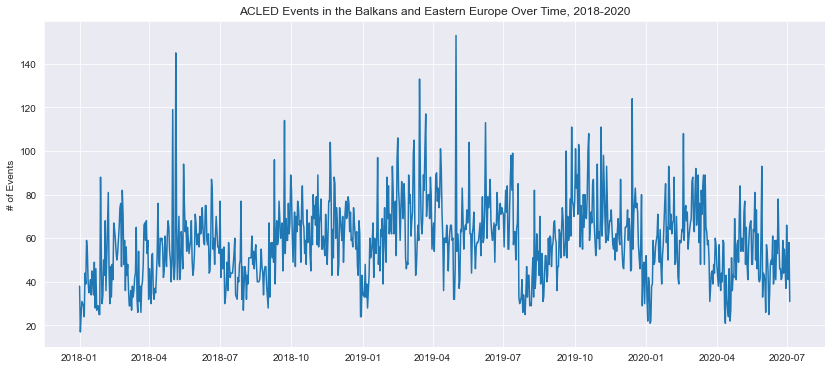

In [49]:
# Line graph of all events
sns.set_style('darkgrid')
plt.figure(figsize=(14, 6))
sns.lineplot(data=Europe_data.event_date.value_counts(), palette='rainbow')
plt.title('ACLED Events in the Balkans and Eastern Europe Over Time, 2018-2020')
plt.ylabel('# of Events')

Next, I want to get an idea of what type of events occur most often, and what countries they most frequently occur in.

Text(0.5, 1.0, 'ACLED Events in the Balkans and Eastern Europe by Country, 2018-2020')

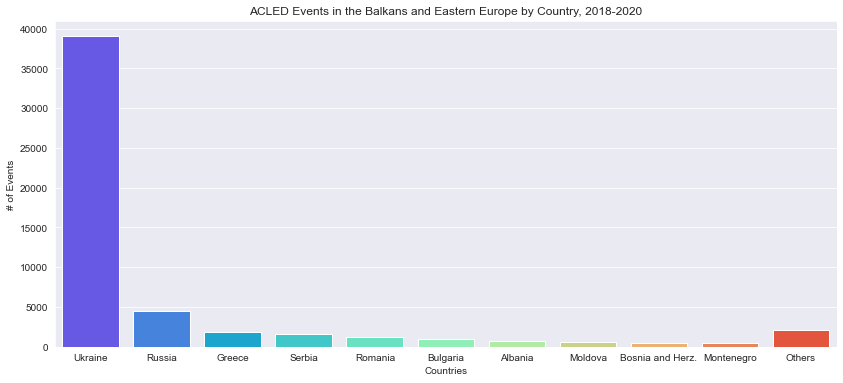

In [50]:
# Bar graph of country representation

# Get country count
country_count = Europe_data.country.value_counts()

# Turn all countries represented less than 500 times into an 'other' category
country_count_under_500 = country_count.loc[country_count < 500]
country_count_excl_others = country_count.loc[country_count >= 500]
country_count_others = pd.Series([country_count_under_500.sum()], index=['Others'])
country_count_with_others = pd.concat([country_count_excl_others, country_count_others])

# Graph it
plt.figure(figsize=(14, 6))
sns.barplot(x=country_count_with_others.index, y=country_count_with_others, palette='rainbow')
plt.xlabel('Countries')
plt.ylabel('# of Events')
plt.title('ACLED Events in the Balkans and Eastern Europe by Country, 2018-2020')

In [51]:
# Choropleth map of events by country

# Get folium base map
m = fol.Map(location=[60, 70], zoom_start=3, tiles='cartodbpositron')

# Get geo data frame with European borders, with index as country names
Europe_borders = world.loc[world.continent == 'Europe']
Europe_borders_simple = Europe_borders[['name', 'geometry']].set_index('name')
Europe_borders_simple.to_crs(epsg=3857)

# Graph with folium
fol.Choropleth(
    geo_data=Europe_borders_simple,
    data=country_count,
    key_on='feature.id',
    fill_color='Reds',
    line_opacity=0.2,
    nan_fill_color='None',
    legend_name='ACLED Events, 2018-2020'
).add_to(m)
fol.LayerControl().add_to(m)
m


Both the bar graph and choropleth map show that Ukraine is a massive outlier; in fact, it's such an outlier that it obscures the differences between the other countries on the choropleth map. To visualize these differences, it should be useful to have another choropleth map that excludes Ukraine.

In [52]:
# Choropleth without Ukraine

# Exclude Ukraine from country count
country_count_no_UA = country_count.drop('Ukraine')

# Graph with Folium
m = fol.Map(location=[60, 70], zoom_start=3, tiles='cartodbpositron')
fol.Choropleth(
    geo_data=Europe_borders_simple,
    data=country_count_no_UA,
    key_on='feature.id',
    fill_color='Reds',
    line_opacity=0.2,
    nan_fill_color='None',
    legend_name='ACLED Events, 2018-2020 (Ukraine Excluded)'
).add_to(m)
fol.LayerControl().add_to(m)
m


Both maps are useful for different purposes; the first establishes that Ukraine had by far the most ACLED events, while the second shows the smaller differences between other countries in the Balkans and Eastern Europe.

Text(0.5, 1.0, 'ACLED Events in the Balkans and Eastern Europe by Event Type, 2018-2020')

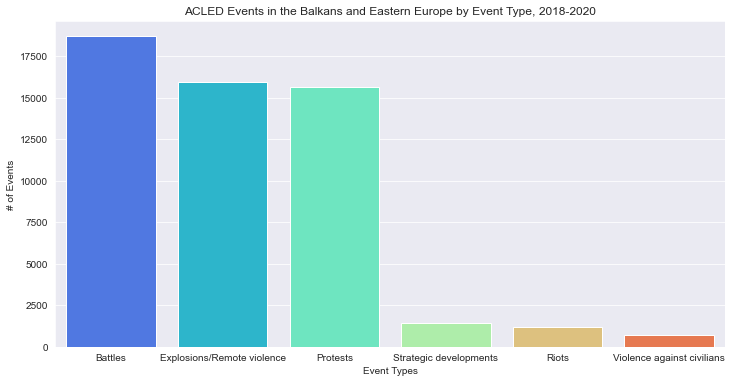

In [53]:
# Bar graph of different types of events

# Get event count
event_type_count = Europe_data.event_type.value_counts()

# Graph it
plt.figure(figsize=(12, 6))
sns.barplot(x=event_type_count.index, y=event_type_count, palette='rainbow')
plt.xlabel('Event Types')
plt.ylabel('# of Events')
plt.title('ACLED Events in the Balkans and Eastern Europe by Event Type, 2018-2020')

The Ukraine Crisis and the War in Donbass have a dramatic impact, as Ukraine is by far the most frequently represented in the data set. It's a significant outlier. This conflict likely also accounts for the frequency of battles. Focusing on the Ukraine conflict should be promising.

# The Ukraine Conflict

Text(0.5, 1.0, 'ACLED Events in Ukraine Over Time')

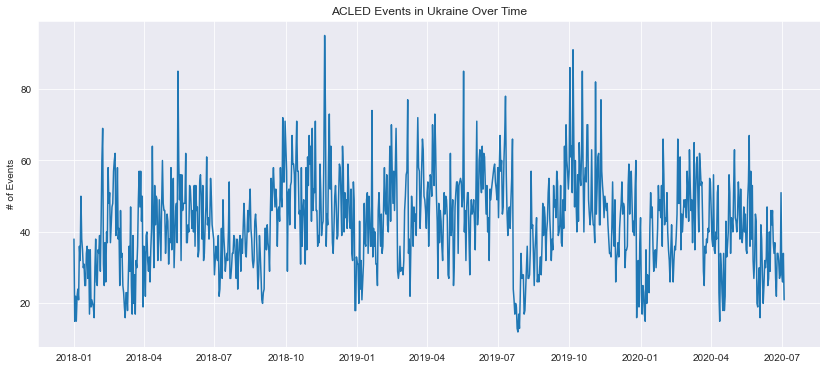

In [54]:
# Line graph of all events in Ukraine

# Get data
UA_data = Europe_data.loc[Europe_data.country == 'Ukraine']

# Graph it
plt.figure(figsize=(14, 6))
sns.lineplot(data=UA_data.event_date.value_counts(), palette='rainbow')
plt.ylabel('# of Events')
plt.title('ACLED Events in Ukraine Over Time')

ACLED events in general have been on a downward trend since the end of 2019, with a noticable trough in April. It's possible that some events were impacted by the pandemic. A similar downturn occurred in the summer of 2019, with an upward trend following. Let's look at the event types in more detail.

Text(0, 0.5, '# of Events')

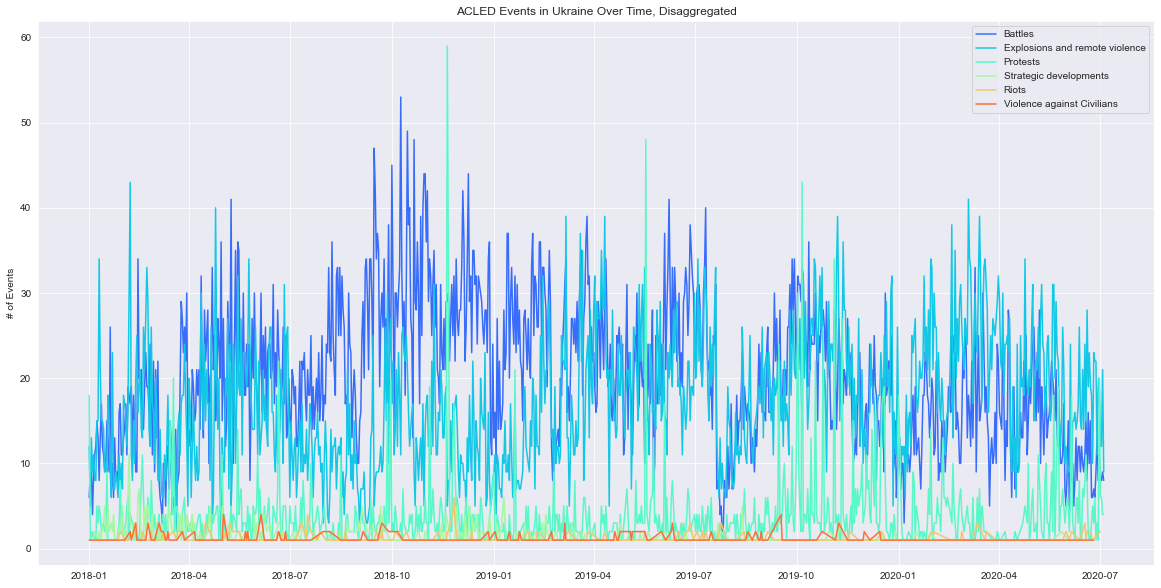

In [55]:
# Line graph of disaggregated event types in Ukraine

# Separating out event types
UA_battles_OT = UA_data.loc[UA_data.event_type == 'Battles'].event_date.value_counts()
UA_explosions_OT = UA_data.loc[UA_data.event_type == 'Explosions/Remote violence'].event_date.value_counts()
UA_protests_OT = UA_data.loc[UA_data.event_type == 'Protests'].event_date.value_counts()
UA_strategic_OT = UA_data.loc[UA_data.event_type == 'Strategic developments'].event_date.value_counts()
UA_riots_OT = UA_data.loc[UA_data.event_type == 'Riots'].event_date.value_counts()
UA_civ_violence_OT = UA_data.loc[UA_data.event_type == 'Violence against civilians'].event_date.value_counts()

# Putting them back together as individual columns in a dataframe
UA_events_OT = pd.DataFrame({'Battles':UA_battles_OT,
                                  'Explosions and remote violence':UA_explosions_OT, 
                                  'Protests':UA_protests_OT,
                                  'Strategic developments': UA_strategic_OT,
                                  'Riots': UA_riots_OT,
                                  'Violence against Civilians':UA_civ_violence_OT})

# Graph it
plt.figure(figsize=(20, 10))
sns.lineplot(data=UA_events_OT, palette='rainbow', dashes=False)
plt.title('ACLED Events in Ukraine Over Time, Disaggregated')
plt.ylabel('# of Events')


As in the dataset as a whole, strategic developments, riots, and violence against civilians occur less frequently than the other categories. Battles and explosions/remote violence seem to follow similar trends, while protests occur in short bursts. They don't follow the battles and explosions/remote violence trend closely, although their spikes do seem to correlate somewhat with peaks in those two categories. An interesting exception is the period between mid-April and June, which as seen a decline in battles and explosions/remote violence along with a resumption of protest activity. This is something I'll want to examine when we delve deeper into individual events.

These line graphs give an idea of the timing of ACLED events; now, I'm interested in their locations. Where in Ukraine do these events tend to cluster?

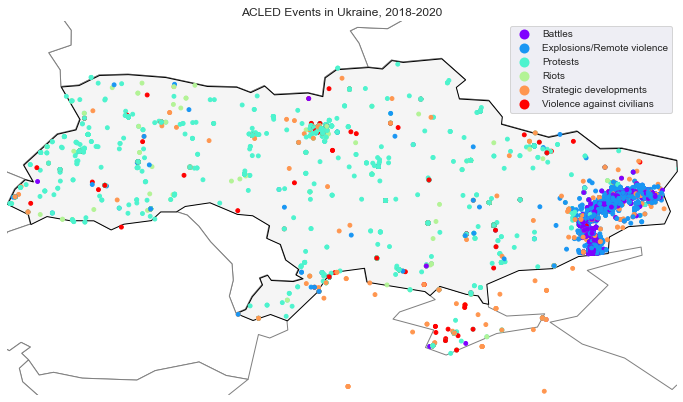

In [56]:
# Mapping Events in Ukraine

# Make a geo data frame out of Ukraine_data
UA_data_geo = gpd.GeoDataFrame(UA_data, geometry=gpd.points_from_xy(UA_data['longitude'], UA_data['latitude']))
UA_data_geo.crs = {'init', 'epsg:4326'}

# Zoom in on Ukraine
UA_borders = world.loc[world['name'] == 'Ukraine']
UA_bounds = UA_borders.geometry.total_bounds
UA_bounds[1] = UA_bounds[1] - 2
UA_bounds[3] = UA_bounds[3] + 1
ax = Europe_borders.plot(figsize=(12, 12), color='white', edgecolor='gray')
xlim = ([UA_bounds[0],  UA_bounds[2]])
ylim = ([UA_bounds[1],  UA_bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Map events
UA_borders.plot(ax=ax, color='whitesmoke', edgecolor='black')
UA_data_geo.plot(ax=ax, markersize=15, column='event_type', legend=True, cmap='rainbow')
ax.set(title='ACLED Events in Ukraine, 2018-2020')
ax.set_axis_off()

Protests have occurred throughout the country, though there seems to be a cluster around Kiev in the north. Strategic developments have occurred primarily, though not exclusively, on the eastern border, in Crimea, and around Kiev. Violence against civilians seems to have been more common in Crimea as well. The most obvious trends are evident with battles and remote violence/explosions, both of which are clustered around the eastern edge of the country.

While this map is interesting, it's missing any demographic data. For instance, language is often cited as creating an important dynamic in the Ukraine conflict. Although bilingualism is common throughout the country, Ukrainian is generally more commonly spoken in the west, with Russian being spoken more frequently in the east. Some argue that this division has been politicized throughout the conflict, with Russia claiming to protect Ukraine's Russian-speaking population (Matviyishyn, 2020). How do the ACLED events line up with these demographic trends?

Text(69.34, 7627, 'Luhanska')

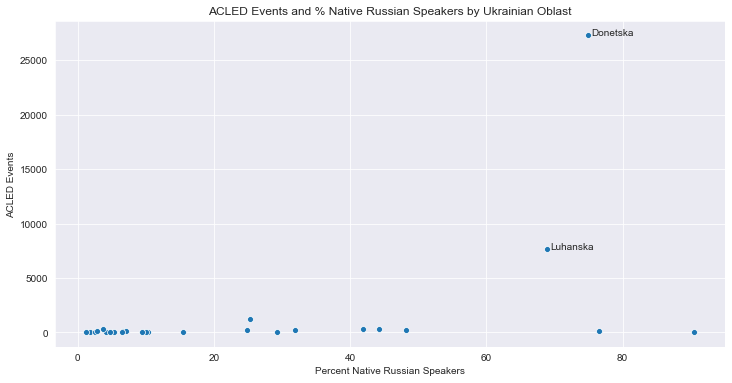

In [57]:
# Scatterplot of % Russian speakers and ACLED events

# Get language and event data
UA_Russian_and_events_filepath = r"C:\Users\efras\OneDrive\Documents\Personal\Data and Analysis\Ukraine Russian Speakers and ACLED Events.csv"
UA_Russian_and_events = pd.read_csv(UA_Russian_and_events_filepath)

# Make scatterplot
plt.figure(figsize=(12, 6))
p1 = sns.scatterplot(x=UA_Russian_and_events['Percent Native Russian Speakers'], y=UA_Russian_and_events['ACLED Events'])
plt.title('ACLED Events and % Native Russian Speakers by Ukrainian Oblast')

# Annotate outliers with Oblast names
p1.text(74.92+0.5, 27289, 'Donetska')
p1.text(68.84+0.5, 7627, 'Luhanska')

First, it should be noted that the language data is quite old. The last Ukrainian census was in 2001, and the language data is from that year.

Rather than a clear trend based on percentages of native Russian speakers, this dataset shows that two oblasts - Luhansk and Donetsk - have dramatically higher numbers of ACLED events than the others. While demographics may well play a role in patterns of unrest in the Ukraine, the impact of geography and proximity to the Russian border seems much clearer in this data. 

The ACLED dataset gives us the times, types, and locations of the events; it also includes the actors involved in them. Let's explore this variable for the Ukraine conflict.

[Text(0, 0, 'NAF: United Armed Forces of Novorossiya'),
 Text(0, 0, 'Military Forces of Ukraine (2014-2019)'),
 Text(0, 0, 'Military Forces of Ukraine (2019-)'),
 Text(0, 0, 'Protesters (Ukraine)'),
 Text(0, 0, 'Civilians (Ukraine)'),
 Text(0, 0, 'Unidentified Armed Group (Ukraine)'),
 Text(0, 0, 'Rioters (Ukraine)'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Police Forces of Ukraine (2014-2019)'),
 Text(0, 0, 'Police Forces of Ukraine (2014-2019) Security Service of Ukraine'),
 Text(0, 0, 'Police Forces of Ukraine (2019-)')]

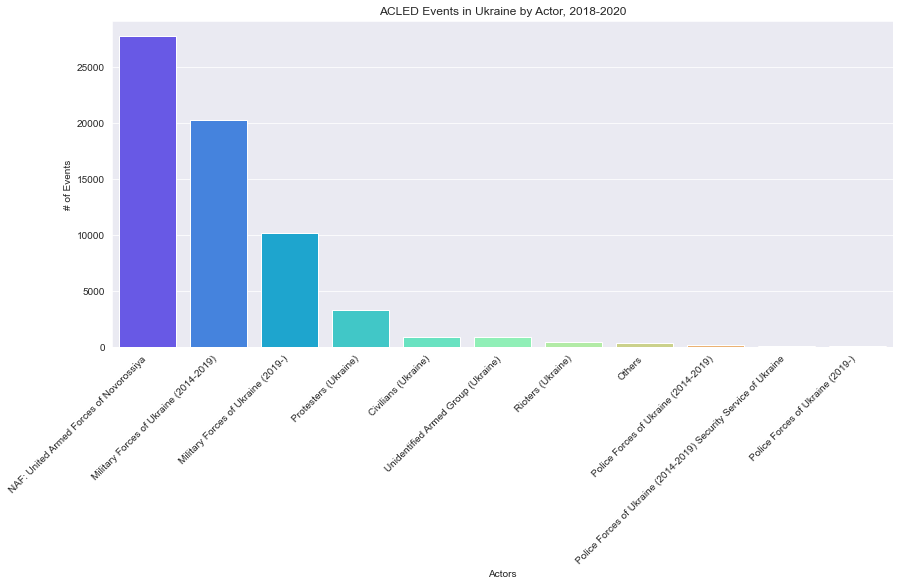

In [58]:
# Bar graph of most frequent actors

# Get actor data
UA_actor1_counts = UA_data.actor1.value_counts()
UA_actor2_counts = UA_data.actor2.value_counts()

# Combine data for actor1 and actor2
UA_actor_counts_combined = pd.concat([UA_actor1_counts, UA_actor2_counts]).to_frame().reset_index()
UA_actor_counts_combined.columns = ['Actor', 'Events']
UA_actor_counts_combined = UA_actor_counts_combined.groupby('Actor').Events.sum()

# Make an 'others' column
UA_actor_counts_under_50 = UA_actor_counts_combined.loc[UA_actor_counts_combined < 50]
UA_actor_counts_excl_others = UA_actor_counts_combined.loc[UA_actor_counts_combined >= 50]
UA_actor_counts_others = pd.Series([UA_actor_counts_under_50.sum()], index=['Others'])
UA_actor_counts_with_others = pd.concat([UA_actor_counts_excl_others, UA_actor_counts_others])
UA_actor_counts_with_others = UA_actor_counts_with_others.sort_values(ascending=False)

# Create bar graph
plt.figure(figsize=(14, 6))
bar_graph = sns.barplot(x=UA_actor_counts_with_others.index, y=UA_actor_counts_with_others, palette='rainbow')
plt.xlabel('Actors')
plt.ylabel('# of Events')
plt.title('ACLED Events in Ukraine by Actor, 2018-2020')
bar_graph.set_xticklabels(bar_graph.get_xticklabels(), rotation=45, horizontalalignment='right')


Here, we see that the most common actors are the United Armed Forces of Novorossiya, the Military Forces of Ukraine, and Ukrainian protestors. But what were the most common combinations of actors across the ACLED events?

Text(0.5, 1.0, 'Actor Combinations in Ukraine ACLED Events, 2018-2020')

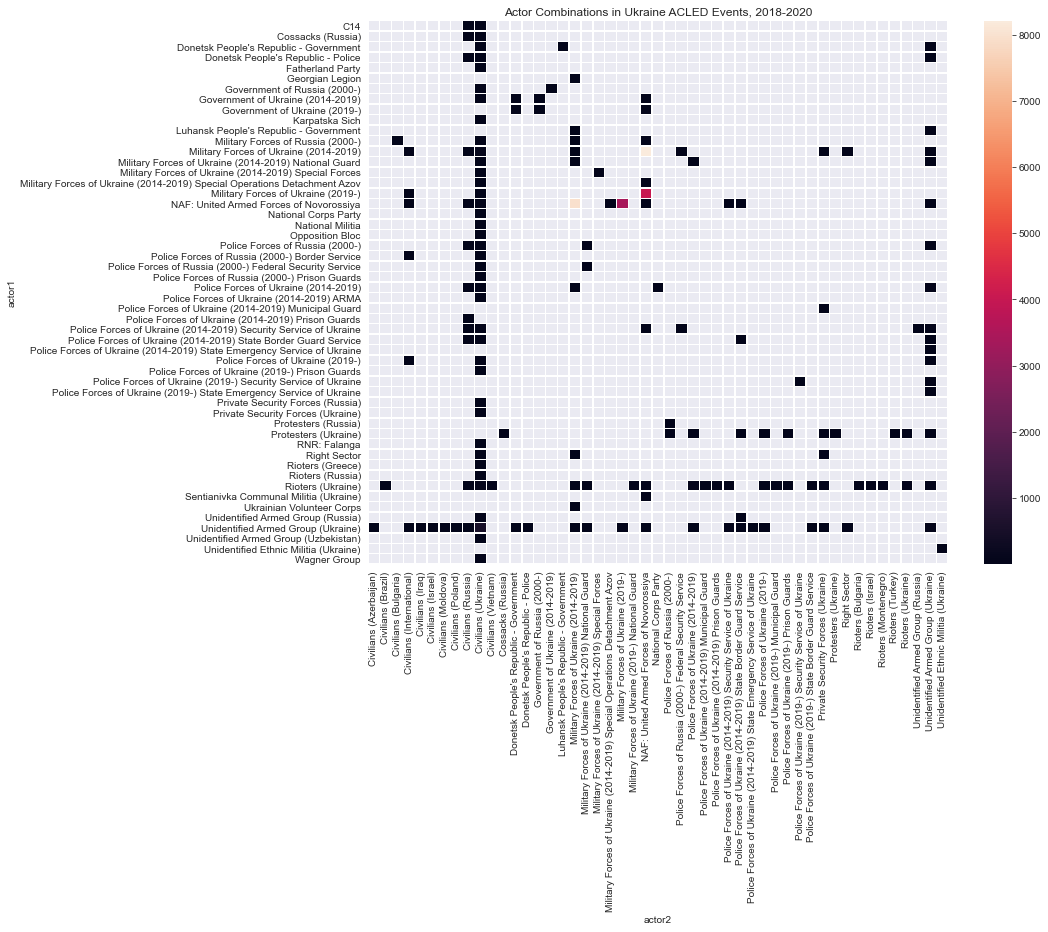

In [59]:
# Heat map showing number of times two actors were in the same event

# Get data frame with just actor1 and actor2 columns, no null values
UA_both_actors = UA_data.loc[:, ['actor1', 'actor2']]
UA_both_actors = UA_both_actors[pd.notnull(UA_both_actors.actor2)]
UA_both_actors = UA_both_actors.replace('Police Forces of Ukraine (2014-2019) ARMA: National Agency for Identifying, Tracing and Managing Assets Obtained through Corruption and Other Crimes', 'Police Forces of Ukraine (2014-2019) ARMA')


# Get counts and reorganize data for heatmap
UA_both_actors = UA_both_actors.groupby(['actor1', 'actor2']).size().reset_index(name='counts')
UA_both_actors_pivoted = UA_both_actors.pivot(index='actor1', columns='actor2', values='counts')       

# Create and style heatmap
plt.figure(figsize=(13, 10))
sns.heatmap(data=UA_both_actors_pivoted, linewidths=0.5)
plt.title('Actor Combinations in Ukraine ACLED Events, 2018-2020')



Evidently, the most common actor combinations include Military Forces of Ukraine, either from 2014 to 2019 or from 2019 onwards, and the United Armed Forces of Novorossiya. Furthermore, nearly all of the actors listed in 'actor1' have clashed with Ukrainian civilians, and most have opposed unidentified Ukrainian armed groups. Unidentified Ukrainian armed groups are also commonly involved with the actors listed in 'actor2'.

# Conclusion

Although this is a beginner project, I do think that it emphasizes and displays interesting trends and relationships in the ACLED data. As my programming skills improve, I hope to work on more sophisticated projects that apply data analysis and visualization to topics in international affairs. 

# Sources
Armed Conflict Location & Event Data Project (ACLED). (2020, August 1). *Eastern & Southeastern Europe.* https://acleddata.com/curated-data-files/.

Government of Ukraine. *Databank of State Statistics Service of Ukraine.* http://database.ukrcensus.gov.ua/MULT/Dialog/statfile.asp?lang=2

Matviyishyn, I. (2020, June 25). *How Russia weaponizes the language issue in Ukraine.* Atlantic Council. https://www.atlanticcouncil.org/blogs/ukrainealert/putin-is-the-only-winner-of-ukraines-language-wars/.

United Nations Office for the Coordination of Humanitarian Affairs in Ukraine. *Ukraine - Subnational Administrative Boundaries.* Humanitarian Data Exchange https://data.humdata.org/dataset/ukraine-administrative-boundaries-as-of-q2-2017.